In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
import tensorflow.contrib.metrics as metrics
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

tf.set_random_seed(1)
np.random.seed(1)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


In [2]:
#Just for drawing.
import itertools
def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
#scaling
df = pd.read_csv('creditcard.csv')
df = df.sample(frac=1).reset_index(drop=True)
               
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

In [4]:
#Original Data => Original test & Original Train using Striatified for saving data structure
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold

x = df.drop(['Class','scaled_time'], axis=1) #better performace... 
y = df['Class']

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
np.sum(y_train)

(227846, 29) (227846, 1) (56961, 29) (56961, 1)


394

from sklearn.metrics import mean_squared_error

epochs = 4000
lr = 1e-3
hidden_layers1 = 30
hidden_layers2 = 20

cost_history = np.empty(shape=[1],dtype=float)

#model
X = tf.placeholder(tf.float32,(None,30))
Y = tf.placeholder(tf.float32,(None,1))
is_training = tf.Variable(True, dtype=tf.bool)
initializer = tf.keras.initializers.glorot_normal(seed=None)

h0 = tf.layers.dense(X,hidden_layers1, activation = tf.nn.elu, kernel_initializer = initializer, use_bias=True,
                     bias_initializer = tf.ones_initializer())
dropout0 = tf.layers.dropout(h0, rate=0.6)

h1 = tf.layers.dense(dropout0, hidden_layers2, activation = tf.nn.elu,kernel_initializer=initializer, 
                     use_bias=True, bias_initializer = tf.ones_initializer())
dropout1 = tf.layers.dropout(h1, rate=0.5)
h2 = tf.layers.dense(dropout1, 1, activation=None)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=h2) #try weight
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)
#optimizer=tf.train.ProximalGradientDescentOptimizer(learning_rate=lr).minimize(cost)
#optimizer=tf.train.RMSPropOptimizer(learning_rate=lr).minimize(cost)
predicted = tf.nn.sigmoid(h2)
correct_pred = tf.equal(tf.round(predicted),Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

In [5]:
from sklearn.metrics import mean_squared_error

epochs = 2000
lr = 1e-3
hidden_layers1 = 30
hidden_layers2 = 20

cost_history = np.empty(shape=[1],dtype=float)

#model
X = tf.placeholder(tf.float32,(None,29))
Y = tf.placeholder(tf.float32,(None,1))
is_training = tf.Variable(True, dtype=tf.bool)
initializer = tf.keras.initializers.glorot_normal(seed=None)

h0 = tf.layers.dense(X,hidden_layers1, activation = tf.nn.leaky_relu, kernel_initializer = initializer, use_bias=True,
                     bias_initializer = tf.ones_initializer())
dropout0 = tf.layers.dropout(h0, rate=0.6)

h1 = tf.layers.dense(dropout0, hidden_layers2, activation = tf.nn.leaky_relu,kernel_initializer=initializer, 
                     use_bias=True, bias_initializer = tf.ones_initializer())
dropout1 = tf.layers.dropout(h1, rate=0.5)
h2 = tf.layers.dense(dropout1, 1, activation=None)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=h2) #try weight
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)
#optimizer=tf.train.ProximalGradientDescentOptimizer(learning_rate=lr).minimize(cost)
#optimizer=tf.train.RMSPropOptimizer(learning_rate=lr).minimize(cost)
predicted = tf.nn.sigmoid(h2)
correct_pred = tf.equal(tf.round(predicted),Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Step:     0	Loss: 1.600	Acc: 5.77%
Step:   100	Loss: 0.007	Acc: 99.92%
Step:   200	Loss: 0.004	Acc: 99.94%
Step:   300	Loss: 0.004	Acc: 99.94%
Step:   400	Loss: 0.003	Acc: 99.94%
Step:   500	Loss: 0.003	Acc: 99.95%
Step:   600	Loss: 0.003	Acc: 99.95%
Step:   700	Loss: 0.003	Acc: 99.95%
Step:   800	Loss: 0.003	Acc: 99.95%
Step:   900	Loss: 0.003	Acc: 99.95%
Step:  1000	Loss: 0.003	Acc: 99.95%
Step:  1100	Loss: 0.002	Acc: 99.95%
Step:  1200	Loss: 0.002	Acc: 99.95%
Step:  1300	Loss: 0.002	Acc: 99.95%
Step:  1400	Loss: 0.002	Acc: 99.95%
Step:  1500	Loss: 0.002	Acc: 99.95%
Step:  1600	Loss: 0.002	Acc: 99.96%
Step:  1700	Loss: 0.002	Acc: 99.96%
Step:  1800	Loss: 0.002	Acc: 99.96%
Step:  1900	Loss: 0.002	Acc: 99.96%
Step:  2000	Loss: 0.002	Acc: 99.96%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.90      0.79      0.84        98

    accuracy                           1.00     56961
   macro avg       0.95    

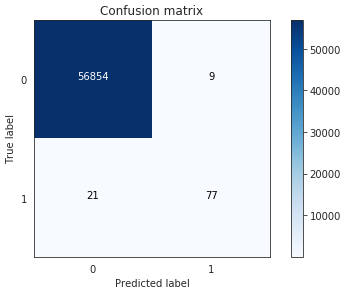

<Figure size 360x360 with 0 Axes>

In [6]:
#session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(epochs+1):
        sess.run(optimizer,feed_dict={X: x_train,Y: y_train})
        loss, _,acc=sess.run([cost,optimizer,accuracy],feed_dict={X: x_train, Y: y_train})
        cost_history=np.append(cost_history,acc)
        if step % 100 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step,loss,acc))
    test_predict_result=sess.run(tf.cast(tf.round(predicted),tf.int32),feed_dict={X:x_test})
print(classification_report(y_test,test_predict_result))
print("Accuracy",(accuracy_score(y_test,test_predict_result)))
cm=confusion_matrix(y_test,test_predict_result)
print(cm)

with sns.axes_style("white"):
    plot_confusion_matrix(cm)
plt.figure(figsize=(5,5))
plt.show()

In [7]:
##UnderSampling
nm = NearMiss()
x_train_u, y_train_u = nm.fit_sample(x_train, y_train)
y_train_u = y_train_u.reshape(-1,1)
x_train_u.shape, y_train_u.shape

((788, 29), (788, 1))

Step:     0	Loss: 0.675	Acc: 59.26%
Step:   100	Loss: 0.111	Acc: 96.95%
Step:   200	Loss: 0.088	Acc: 97.46%
Step:   300	Loss: 0.068	Acc: 98.10%
Step:   400	Loss: 0.052	Acc: 98.48%
Step:   500	Loss: 0.037	Acc: 98.86%
Step:   600	Loss: 0.024	Acc: 99.11%
Step:   700	Loss: 0.015	Acc: 99.49%
Step:   800	Loss: 0.010	Acc: 99.87%
Step:   900	Loss: 0.008	Acc: 99.87%
Step:  1000	Loss: 0.006	Acc: 99.87%
Step:  1100	Loss: 0.005	Acc: 99.87%
Step:  1200	Loss: 0.004	Acc: 99.87%
Step:  1300	Loss: 0.003	Acc: 99.87%
Step:  1400	Loss: 0.003	Acc: 99.87%
Step:  1500	Loss: 0.003	Acc: 99.87%
Step:  1600	Loss: 0.002	Acc: 99.87%
Step:  1700	Loss: 0.002	Acc: 99.87%
Step:  1800	Loss: 0.002	Acc: 100.00%
Step:  1900	Loss: 0.002	Acc: 100.00%
Step:  2000	Loss: 0.001	Acc: 100.00%
              precision    recall  f1-score   support

           0       1.00      0.39      0.56     56863
           1       0.00      0.94      0.01        98

    accuracy                           0.39     56961
   macro avg       0.50

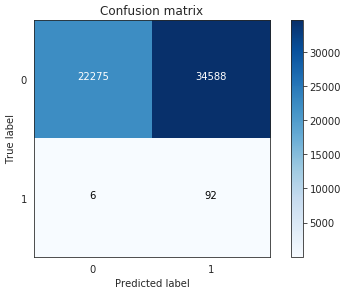

<Figure size 360x360 with 0 Axes>

In [8]:
#session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(epochs+1):
        sess.run(optimizer,feed_dict={X: x_train_u,Y: y_train_u})
        loss, _,acc=sess.run([cost,optimizer,accuracy],feed_dict={X: x_train_u, Y: y_train_u})
        cost_history=np.append(cost_history,acc)
        if step % 100 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step,loss,acc))
    test_predict_result=sess.run(tf.cast(tf.round(predicted),tf.int32),feed_dict={X:x_test})
print(classification_report(y_test,test_predict_result))
print("Accuracy",(accuracy_score(y_test,test_predict_result)))
cm=confusion_matrix(y_test,test_predict_result)
print(cm)

with sns.axes_style("white"):
    plot_confusion_matrix(cm)
plt.figure(figsize=(5,5))
plt.show()

In [9]:
##OverSampling
ss = SVMSMOTE(sampling_strategy='minority')
x_train_o, y_train_o = ss.fit_sample(x_train, y_train)
y_train_o = y_train_o.reshape(-1,1)
x_train_o.shape, y_train_o.shape

((454904, 29), (454904, 1))

Step:     0	Loss: 0.878	Acc: 51.02%
Step:   100	Loss: 0.032	Acc: 99.00%
Step:   200	Loss: 0.022	Acc: 99.31%
Step:   300	Loss: 0.018	Acc: 99.43%
Step:   400	Loss: 0.015	Acc: 99.53%
Step:   500	Loss: 0.013	Acc: 99.63%
Step:   600	Loss: 0.011	Acc: 99.74%
Step:   700	Loss: 0.009	Acc: 99.80%
Step:   800	Loss: 0.007	Acc: 99.85%
Step:   900	Loss: 0.006	Acc: 99.88%
Step:  1000	Loss: 0.006	Acc: 99.90%
Step:  1100	Loss: 0.005	Acc: 99.92%
Step:  1200	Loss: 0.004	Acc: 99.93%
Step:  1300	Loss: 0.004	Acc: 99.94%
Step:  1400	Loss: 0.004	Acc: 99.95%
Step:  1500	Loss: 0.003	Acc: 99.95%
Step:  1600	Loss: 0.003	Acc: 99.95%
Step:  1700	Loss: 0.003	Acc: 99.96%
Step:  1800	Loss: 0.002	Acc: 99.96%
Step:  1900	Loss: 0.002	Acc: 99.96%
Step:  2000	Loss: 0.002	Acc: 99.97%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.63      0.87      0.73        98

    accuracy                           1.00     56961
   macro avg       0.82   

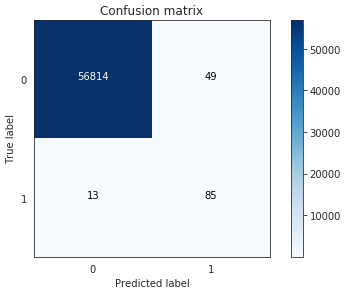

<Figure size 360x360 with 0 Axes>

In [10]:
#session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(epochs+1):
        sess.run(optimizer,feed_dict={X: x_train_o,Y: y_train_o})
        loss, _,acc=sess.run([cost,optimizer,accuracy],feed_dict={X: x_train_o, Y: y_train_o})
        cost_history=np.append(cost_history,acc)
        if step % 100 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step,loss,acc))
    test_predict_result=sess.run(tf.cast(tf.round(predicted),tf.int32),feed_dict={X:x_test})
print(classification_report(y_test,test_predict_result))
print("Accuracy",(accuracy_score(y_test,test_predict_result)))
cm=confusion_matrix(y_test,test_predict_result)
print(cm)

with sns.axes_style("white"):
    plot_confusion_matrix(cm)
plt.figure(figsize=(5,5))
plt.show()